Personal Training ipynb. Not for public use!!!! Please ref to YouTube tutorials: Machine Learning with JAX - From Xero to Hero

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import grad, jit, vmap, pmap
from jax import lax
from jax import random
from jax import make_jaxpr
from jax import device_put # push NumPy explicitly to the GPU

### Jax with NumPy

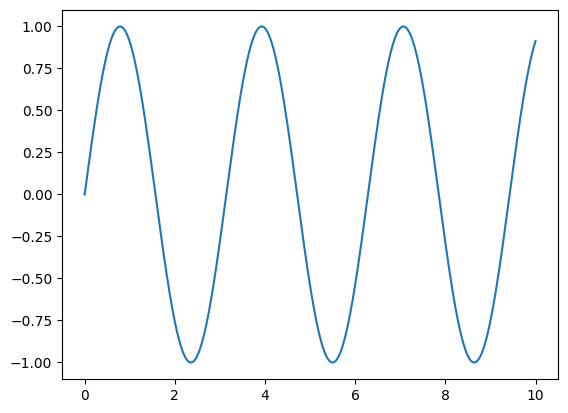

In [3]:
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
#plt.plot(x_np, y_np) would be the same as the jax version below

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)
plt.show()

In [4]:
size = 10
index = 0
value = 23

print("NumPy: mutable arrays")
x = np.arange(size)
print(f'x = {x}')
x[index] = value
print(f'x = {x}')

print("JAX: immutable arrays")
x = jnp.arange(size)
print(f'x = {x}')
#x[index] = value #Jax is immutable, so this is not callable
# Solution
y = x.at[index].set(value)
print(f'y = {y}')
print("we should make a new array instead of changing the old one")


NumPy: mutable arrays
x = [0 1 2 3 4 5 6 7 8 9]
x = [23  1  2  3  4  5  6  7  8  9]
JAX: immutable arrays
x = [0 1 2 3 4 5 6 7 8 9]
y = [23  1  2  3  4  5  6  7  8  9]
we should make a new array instead of changing the old one


In [5]:
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10,))
print(type(x), x)

y = random.normal(key, (10,))
print(type(y), y)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]
<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


### JAX transformation functions

#### jit()

#### grad()
Differentiation can be: 1. manual; 2. symbolic; 3. numeric; 4. automatic!

In [6]:
# First example: automatic differentiation

def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic

grad_loss = grad(loss)

print(grad_loss(x)) # evaluate the gradient at x automatically

[0.25       0.19661197 0.10499357]


In [7]:
# Second example: automatic differentiation

x = 1.
y = 1.

f = lambda x, y: x**2 + x + 4 + y**2

dfdx = grad(f)
d2fdx = grad(dfdx)
d3fdx = grad(d2fdx)

print(f(x, y), dfdx(x, y), d2fdx(x, y), d3fdx(x, y))

dfdy = grad(f, argnums=1)
print(f(x, y), dfdy(x, y))

7.0 3.0 2.0 0.0
7.0 2.0


In [8]:
# JAX sutodiff engine is very powerful!!!!
from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums=(0, 1)))

a = hessian(f)(1., 1.)
print(jnp.asarray(a))

[[2. 0.]
 [0. 2.]]


In [9]:
# Edge case: |x|

f = lambda x: jnp.abs(x)

dfdx = grad(f)

print(dfdx(0.)) # follow x = 0.00000001

1.0


#### vamp
+ Write your function as if you were dealing with a single datapoint

In [10]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(x):
    return jnp.dot(W, x) # only work for single x rather than batched x, i.e., x.shape = (100,)

def naivel_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print("Naively batched")
%timeit naivel_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
647 μs ± 34 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)

print("Manually bathced")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually bathced
13 μs ± 671 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
@jit
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

print("Auto-vectorized with vmap")
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
19.1 μs ± 715 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
# more in line
@jit
def apply_matrix2(W, x):
    return jnp.dot(W, x)

@jit
def vmap_batched_apply_matrix2(W, batched_x):
    return vmap(apply_matrix2, in_axes=(None,0))(W, batched_x)

print("Auto-vectorized with vmap")
%timeit vmap_batched_apply_matrix2(W, batched_x).block_until_ready()

Auto-vectorized with vmap
19.9 μs ± 534 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### JAX API

#### API Layers: NumPy <-> lax <-> XLA
+ lax API is stricter and more powerful

In [14]:
# Example 1: lax is stricter

print(jnp.add(1, 1.)) # one int and one float -- works
print(lax.add(1., 1.)) # both float -- works (int + float = error)

2.0
2.0


In [15]:
# Example 2: lax is more powerful (but not user friendely)

### Details about JIT

In [16]:
# Example of a failure: array shape must be static

def get_negatives(x):
    return x[x<0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))
#print(jit(get_negatives)(x)) however, if with jit, it will cause a failure

[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [17]:
def f(x, y):
    return jnp.dot(x+1, y+1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[10] b:f32[]. let
    c:f32[10] = add a 1.0
    d:f32[] = add b 1.0
    e:f32[] = convert_element_type[new_dtype=float32 weak_type=False] d
    f:f32[10] = mul c e
  in (f,) }


In [18]:
# Workaround: the 'static' arguement

from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(3, False))
print(f(4, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
3
4


In [19]:
# Use NumPy instead of JAX (sometimes)

#Failure example
@jit
def f(x):
    print(x) # Trace
    print(x.shape) # concrete value
    print(jnp.array(x.shape).prod()) # Trace
    # pass a Trace value to make it concrete is unfeasible
    return x.reshape(jnp.array(x.shape).prod())

# Fix Failure: USE NumPy
@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

x = jnp.ones((2, 3))
f(x)

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

### Gotcha

#### Gotcha 1: Pure Functions

+ JAX is designed to work only on pure functions! 

Informal definition on Pure Functions: 

1. All the input data is passed through the function parameters, all the results are output through the function results. 

2. A pure function will always return the same result if invoked with the same inputs.


In [20]:
# Example

def impure_print_side_effect(x):
    print("Excuting function") # side effect
    return x

# The side-effects appear during the first run
print("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effects
# This is beacause JAX now invokes a cached compiled version of the function
print("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

Excuting function
First call:  4.0
Second call:  5.0
Excuting function
Third call, different type:  [5.]


In [21]:
# Example 2

g = 0.

def impure_uses_globals(x):
    return x + g # Violating both 1 and 2

print("First call: ", jit(impure_uses_globals)(4.))

# Lets update g
g = 10.

# Subsequent runs may silentlt use the cached value of the globals
print("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the lates value of the global
print("Third call, different type: ", jit(impure_uses_globals)(jnp.array([5.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [15.]


In [22]:
# Example 3: very important! Haiku/Flax are basically built on top of this

def pure_uses_internal_state(x):

    state = dict(even=0, odd=0)
    for i in range(10):
        state['even' if i % 2 == 0 else 'odd'] += x
    
    return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

50.0


In [23]:
# Example 4: iterations are a no no!

array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0))

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0))

45
0


#### Gotcha 2: In-Place Updates

In [24]:
jax_array = jnp.zeros((3, 3), dtype=jnp.float32)
update_array = jax_array.at[1:,].set(1.)

print("original array unchanged:\n", jax_array)
print("updated array:\n", update_array)

original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [25]:
jax_array = jnp.ones((5, 6))
print("original array\n", jax_array)

new_jax_array = jax_array.at[::2, 3:].add(7.)
print("new array\n", new_jax_array)

original array
 [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
new array
 [[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


#### Gotcha 3: Out-of-Bounds Indexing

In [26]:
# NumPy behaviour

try:
    np.arange(10)[11]
except Exception as e:
    print("Exception{}".format(e))

Exceptionindex 11 is out of bounds for axis 0 with size 10


In [27]:
# JAX behaviour
# 1) update at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currentlty some bugs so just consider the behaviour as undefined

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11]) # example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


#### Gotcha 4: Non-array inputs

In [28]:
# NumPy

print(np.sum([1, 2, 3]))

6


In [29]:
#JAX

try:
    jnp.sum([1, 2, 3])
except TypeError as e:
    print("Exception: {}".format(e))

Exception: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [30]:
# Why? jaxpr to the rescue!!!

def permissive_sum(x):
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    p:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] g
    r:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] i
    t:i32[] = convert_element_type[new_dtype=int32 weak_type=False] j
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] k
    v:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] l
    w:i32[1] = broadcast_in_dim[broadcast_dimensions=() shap

#### Gotcha 5: Random Numbers
JAX's random functions cannot modify PRNG's state, i.e., key is the same if you dont change it.
+ JAX allows same randomness on different batches

In [31]:
# Solution

key = random.PRNGKey(seed)
print('old key: ',key)

key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("  ---SPLIT --> new key: ", key)
print("      --> new subkey: ", subkey, "--> normal", normal_pseudorandom)

# Note 1: you can also split into more subkeys and not just 1
# Note 2: key, subkey no difference, it's only a convention 
# key to generate new keys, and subkey to generate random numbers

old key:  [0 0]
  ---SPLIT --> new key:  [4146024105  967050713]
      --> new subkey:  [2718843009 1272950319] --> normal [-1.2515389]


#### Gotcha 6: Control Flow

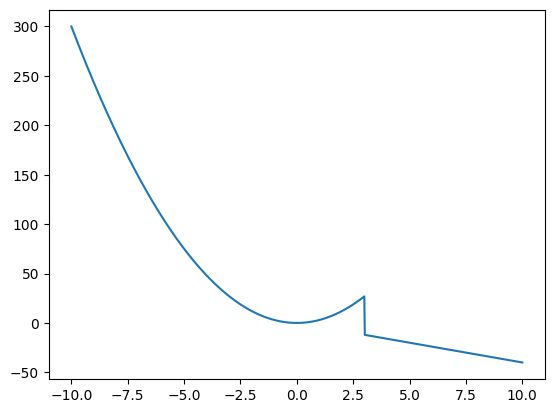

12.0
-4.0


In [32]:
# Python control flow + grad() -> everything is fine
def f(x):
    if x<3:
        return 3. * x**2
    else:
        return -4 * x

x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y); plt.show()

print(grad(f)(2.)) # works!
print(grad(f)(4.)) # works!

In [33]:
f_jit = jit(f, static_argnums=(0,))
x = 2.

print(f_jit(x)) # works!
print(make_jaxpr(f_jit, static_argnums=(0,))(x)) # works!
# print(grad(f_jit)(x)) # Fail

12.0
{ lambda ; . let
    a:f32[] = pjit[name=f jaxpr={ lambda ; . let  in (12.0,) }] 
  in (a,) }


In [38]:
# use lax.cond to make it work

def f(x):
    return lax.cond(x<3,
                    lambda x: 3. * x**2,
                    lambda x: -4 *x,
                    x)

f_jit = jit(f)
grad(f_jit)(2.)

Array(12., dtype=float32, weak_type=True)

In [35]:
# Example 2: range depends on value again

def f(x, n):
    y = 0.
    for i in range(n):
        y += x[i]
    return y

f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2., 3., 4.]), 15)

print(*x)
# print(make_jaxpr(f_jit, static_argnums=(1,))(*x))
print(f_jit(*x)) 

[2. 3. 4.] 15
57.0


In [39]:
# Better soluyion

def f_fori(x, n):
    body_fn = lambda i, val: val + x[i]
    return lax.fori_loop(0, n, body_fn, 0.)

f_fori_jit = jit(f_fori)

print(make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

{ lambda ; a:f32[3] b:i32[]. let
    c:f32[] = pjit[
      name=f_fori
      jaxpr={ lambda ; d:f32[3] e:i32[]. let
          _:i32[] _:i32[] f:f32[] = while[
            body_jaxpr={ lambda ; g:f32[3] h:i32[] i:i32[] j:f32[]. let
                k:i32[] = add h 1
                l:bool[] = lt h 0
                m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
                n:i32[] = add m 3
                o:i32[] = select_n l h n
                p:f32[1] = dynamic_slice[slice_sizes=(1,)] g o
                q:f32[] = squeeze[dimensions=(0,)] p
                r:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] j
                s:f32[] = add r q
              in (k, i, s) }
            body_nconsts=1
            cond_jaxpr={ lambda ; t:i32[] u:i32[] v:f32[]. let
                w:bool[] = lt t u
              in (w,) }
            cond_nconsts=0
          ] d 0 e 0.0
        in (f,) }
    ] a b
  

In [42]:
# Example 3

def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.)
        return ln_x / ln_2
    else:
        return x
    
print(make_jaxpr(log2_if_rank_2)(jnp.array([1, 2, 3])))
print(make_jaxpr(log2_if_rank_2)(jnp.array([(1, 2, 3), (1, 2, 3)])))

{ lambda ; a:i32[3]. let  in (a,) }
{ lambda ; a:i32[2,3]. let
    b:f32[2,3] = convert_element_type[new_dtype=float32 weak_type=False] a
    c:f32[2,3] = log b
    d:f32[] = log 2.0
    e:f32[] = convert_element_type[new_dtype=float32 weak_type=False] d
    f:f32[2,3] = div c e
  in (f,) }


#### Gotcha 7: NaNs

In [48]:
# jnp.divide(0, 0) # wont return failure but a nan value

# If we want to debug where the NaNs are coming from, there ar multiple ways to do this
from jax import config
config.update("jax_debug_nans", True)

In [50]:
# JAX enforce single precision! There are simple ways around it

x = random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype) # use Flax to change the default settings

float32


C:\Users\wurui\AppData\Local\Temp\ipykernel_6100\1987774365.py:3: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x = random.uniform(key, (1000,), dtype=jnp.float64)
